In [83]:
import pandas as pd
import glob
import os
import regex as re
import string
from CommentsDetection import TextMining as tm
from CommentsDetection import openewfile as of
from CommentsDetection import CleanText as ct
from tqdm import tqdm
import time
import seaborn as sns
import datetime
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from tqdm import tqdm
from textblob import TextBlob
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from spacy.lang.id import Indonesian
#from spacy.lang.id.stop_words import STOP_WORDS
import warnings; warnings.simplefilter('ignore')

In [4]:
df = pd.read_csv("..\Data\Data Label\comments_Label_2000.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video_Id     2000 non-null   object 
 1   Tittle       2000 non-null   object 
 2   Name         2000 non-null   object 
 3   Comment      2000 non-null   object 
 4   Comment_Id   2000 non-null   object 
 5   Time         2000 non-null   object 
 6   Likes        2000 non-null   int64  
 7   Reply_Count  1647 non-null   float64
 8   Label        2000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 140.8+ KB


In [5]:
df["Label"] = df["Label"].astype("category")
df["Time"] = df["Time"].astype("datetime64")

In [6]:
df.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0.0,legitimate
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0.0,legitimate
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0.0,legitimate
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0.0,legitimate
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0.0,legitimate


In [7]:
df.isnull().sum()

Video_Id         0
Tittle           0
Name             0
Comment          0
Comment_Id       0
Time             0
Likes            0
Reply_Count    353
Label            0
dtype: int64

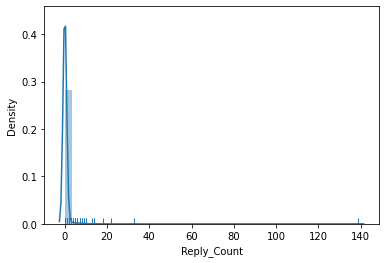

In [8]:
p = sns.distplot(df['Reply_Count'], kde=True, rug=True)

In [9]:
df['Reply_Count'].fillna(df['Reply_Count'].median(),inplace=True)

In [10]:
df.isnull().sum()

Video_Id       0
Tittle         0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [11]:
df["Reply_Count"] = df["Reply_Count"].astype("int64")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Video_Id     2000 non-null   object        
 1   Tittle       2000 non-null   object        
 2   Name         2000 non-null   object        
 3   Comment      2000 non-null   object        
 4   Comment_Id   2000 non-null   object        
 5   Time         2000 non-null   datetime64[ns]
 6   Likes        2000 non-null   int64         
 7   Reply_Count  2000 non-null   int64         
 8   Label        2000 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(5)
memory usage: 127.2+ KB


In [13]:
#count comments words length
def count_length(text):
    return len(text)

In [14]:
df['Length_Comment'] = df['Comment'].apply(lambda x: count_length(x))

In [15]:
df.sample(5)

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
1846,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Indri Dwi,Nonton berkali kali nggak waleh😂,UgypNNfIJCzkriln9YV4AaABAg,2019-04-11 13:16:57,1,0,legitimate,32
404,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Moh Mardin,Akhirnya tersingkirkan juga K-Pop dari trandin...,UgwKtSC3lp8WPAXyKjZ4AaABAg,2019-04-09 19:02:15,1,0,spam,87
1492,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Shaka Asyraf,Njirr nni video gue ulang ulang terus kenapa y...,UgyFu6yhOSQdtWXfCZZ4AaABAg,2019-04-10 23:11:40,0,0,legitimate,52
138,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,8131 Afif Nurwidianto,Wah golput ya bg,UgzJnPQiqebjRKver7p4AaABAg,2019-04-10 01:14:43,0,0,legitimate,16
595,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Pengembara dunia,Jokowi Atau Prabowo ??\nhttps://youtu.be/IACJ_...,UgwwIR4D_ClJYBM2hSF4AaABAg,2019-02-02 05:18:11,0,0,spam,51


## EDA

### Comments that got most 

In [16]:
like = df[df['Likes']==df['Likes'].max()]
print("Komentar dengan like terbanyak adalah {}".format(like.iloc[0].Comment))

Komentar dengan like terbanyak adalah TERIMAKASIH SUDAH MENEMANI KAMI SEMUA SELAMA SEPULUH TAHUN

#thanksforskinnyindonesian24​


### 5 YouTube Account that comments have most reply

In [17]:
account = df['Name'].value_counts().head(5)
account = pd.DataFrame(data=account)
account.reset_index(inplace=True)
account = account.rename(columns = {"index" : "Youtube_Account",
                                    'Name': "reply_count"})
fig = px.bar(account, x='Youtube_Account', y='reply_count',
            color='Youtube_Account', title='10 YouTube Account that comments have most reply')
fig.show()

### Peak time to comments

In [18]:
data = df.copy()
times = data['Time']

In [19]:
def time(date):
    Time = date.time()
    return Time

data['Period'] = times.map(time)
data['Period'].head()

0    11:27:47
1    04:08:18
2    08:57:13
3    16:42:13
4    00:45:06
Name: Period, dtype: object

In [20]:
data1 = data.copy()

def time_groups(time):
    if time >= datetime.time(0,0) and time <= datetime.time(1,0):
        return '12 AM - 1 AM'
    elif time >= datetime.time(1,0) and time <= datetime.time(2,0):
        return '1 AM - 2 AM'
    elif time >= datetime.time(2,0) and time <= datetime.time(3,0):
        return '2 AM - 3 AM'
    elif time >= datetime.time(3,0) and time <= datetime.time(4,0):
        return '3 AM - 4AM'
    elif time >= datetime.time(4,0) and time <= datetime.time(5,0):
        return '4 AM - 5AM'
    elif time >= datetime.time(5,0) and time <= datetime.time(6,0):
        return '5 AM - 6 AM'
    elif time >= datetime.time(6,0) and time <= datetime.time(7,0):
        return '6 AM - 7 AM'
    elif time >= datetime.time(7,0) and time <= datetime.time(8,0):
        return '7 AM - 8 AM'
    elif time >= datetime.time(8,0) and time <= datetime.time(9,0):
        return '8 AM - 9 AM'
    elif time >= datetime.time(9,0) and time <= datetime.time(10,0):
        return '9 AM - 10 AM'
    elif time >= datetime.time(10,0) and time <= datetime.time(11,0):
        return '10 AM - 11 AM'
    elif time >= datetime.time(11,0) and time <= datetime.time(12,0):
        return '11 AM - 12PM'
    elif time >= datetime.time(12,0) and time <= datetime.time(13,0):
        return '12 PM - 1PM'
    elif time >= datetime.time(13,0) and time <= datetime.time(14,0):
        return '1 PM - 2 PM'
    elif time >= datetime.time(14,0) and time <= datetime.time(15,0):
        return '2 PM - 3 PM'
    elif time >= datetime.time(15,0) and time <= datetime.time(16,0):
        return '3 PM - 4 PM'
    elif time >= datetime.time(16,0) and time <= datetime.time(17,0):
        return '4 PM - 5 PM'
    elif time >= datetime.time(17,0) and time <= datetime.time(18,0):
        return '5 PM - 6 PM'
    elif time >= datetime.time(18,0) and time <= datetime.time(19,0):
        return '6 PM - 7 PM'
    elif time >= datetime.time(19,0) and time <= datetime.time(20,0):
        return '7 PM - 8 PM'
    elif time >= datetime.time(20,0) and time <= datetime.time(21,0):
        return '8 PM - 9 PM'
    elif time >= datetime.time(21,0) and time <= datetime.time(22,0):
        return '9 PM - 10 PM'
    elif time >= datetime.time(22,0) and time <= datetime.time(23,0):
        return '10 PM - 11 PM'
    elif time >= datetime.time(23,0) and time <= datetime.time(23,59):
        return '11 PM - 12 AM'
    else:
        return 'other'

In [21]:
data1["Period_groups"] = data1['Period'].map(time_groups)
data1.head()

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,Period,Period_groups
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,legitimate,35,11:27:47,11 AM - 12PM
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,6,04:08:18,4 AM - 5AM
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,18,08:57:13,8 AM - 9 AM
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,7,16:42:13,4 PM - 5 PM
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,38,00:45:06,12 AM - 1 AM


In [22]:
time_group = data1['Period_groups'].value_counts().head(10)
time_group = pd.DataFrame(data=time_group)
time_group.reset_index(inplace=True)
time_group = time_group.rename(columns = {'index':'Time','Period_groups':'Most Comment'})
time_group

fig2 = px.bar(time_group, x='Time', y='Most Comment', 
              color='Time', title = 'Peak Time Comments Video', height=400)
fig2.show()

## Cleaning Text

In [23]:
try_data_cleaning = df.copy()

In [24]:
try_data_cleaning

,Video_Id,Tittle,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Banda vlog,Apa salah mobale lejen pak soekarno,UgwmjTHzY2zMOXBg9F94AaABAg,2019-04-11 11:27:47,0,0,legitimate,35
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,kharisma setya kencana,👆👆👆👆👆👆,UgzbICRmksoeoGVFCzd4AaABAg,2019-04-09 04:08:18,0,0,legitimate,6
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,「GratioKunz」,Dan golput itu apa,UgxROKiw4EX5LyaG0lx4AaABAg,2019-04-18 08:57:13,0,0,legitimate,18
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Trestrantara WZ,Keren!!,UgymN9o3cZFXVPLKcjZ4AaABAg,2019-04-08 16:42:13,0,0,legitimate,7
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Heri Kurniawan,Pilih siapa presiden aku Prabowo-Sandi,Ugw9J8lP4lOg0t5yX0l4AaABAg,2019-04-18 00:45:06,1,0,legitimate,38
...,...,...,...,...,...,...,...,...,...,...
1995,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Inul Rosmeydar,"""Nih BPJS, ngantri lo sana"" :v",Ugxy8JCX7KI-f5xu_8V4AaABAg,2019-04-11 04:18:52,1,0,legitimate,30
1996,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,FAREL AKBAR ADITYA SARAGIH,Gua masih suka lihat ini,Ugz9_8SeFNbW0XDKetZ4AaABAg,2019-08-19 02:36:19,0,0,legitimate,24
1997,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,Craft Lisin,Saya udah 5 kali nonton ini,Ugwc9smbDefrf_4gjSd4AaABAg,2019-04-18 06:07:50,1,0,legitimate,27
1998,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,dahlia triyanti,saya pilih pak prabowo. of cores👌🏻👌🏻👌🏻,Ugznk3WicUm_9xAm4Zp4AaABAg,2019-04-12 08:26:32,0,0,legitimate,38


In [27]:
#NLTK_StopWords = stopwords.words('english')
factory = StopWordRemoverFactory()
Sastrawi_StopWords_id = factory.get_stop_words()

In [28]:
print(Sastrawi_StopWords_id)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [29]:
Sastrawi_StopWords_id = set(Sastrawi_StopWords_id)

In [ ]:
T = "Saya suka makan nasi goreng"

In [94]:
def cleaning(text):
    text = str(text)
    print(f"Text Original : {text}")

    print("\n\n")

    #getHastags
    getHashtags = re.compile(r"#(\w+)")
    pisahtags = re.compile(r'[A-Z][^A-Z]*')
    t = text
    tagS = re.findall(getHashtags, text)
    for tag in tagS:
        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
        t = t.replace('#'+tag, proper_words)
    

    

Cleaning Text


FileNotFoundError: [WinError 3] The system cannot find the path specified: './Stopwords'

In [ ]:
#convert text into lower case
def convert_to_lower(text):
    return text.lower()

#remove_numbers on text
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

'''Komentar spam cenderung memiliki jumlah spasi yang banyak 
sehingga komentar tersebut memberikan dampak yang jauh lebih besar 
bagi pengguna yang membacanya'''
def remove_extra_white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    without_sc = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return without_sc

def remove_stopwords(text):
    nlp = spacy.blank("id")
    removed = []
    stop_words = list(STOP_WORDS)
    Teks = nlp(text)
    #tokens = token.text(Teks)
    for i in range(len(Teks)):
        if Teks [i] not in stop_words:
            removed.append(Teks[i])
    return " ".join(removed)


## Feature Extraction

In [ ]:
def url_ratio(text):
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    url_char = 0
    for url in urls:
        url_char += len(url)
    return url_char/len(text)

def count_url(text):
    urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    return len(urls)

def count_extra_white_spaces(text):
    single_char_pattern = r'\s+'
    without_sc = re.findall(pattern=single_char_pattern, string=text)
    return len(without_sc)

In [ ]:
z = df['Comment'].apply(lambda x: count_extra_white_spaces(x))

In [ ]:
z[402]

In [ ]:
df.Comment[402]

In [ ]:
df['Label'].value_counts()

In [ ]:
ax = sns.countplot(df.Label)
plt.xlabel('Label')